# Raster formats

This section presents the 3 most common file formats for geospatial rasters: JPEG2000, GeoTIFF and COG. The COG format (Cloud Optimized GeoTIFF, http://cogeo.org/) is actually a geotiff format, organized in a way to optimize its usage on cluod infrastructures. For example, it allows the streaming of only the required part of the image, instead of reading it in its entirety.

First, we import all the required libraries.

In [1]:
import time
from pathlib import Path
from utils import download_sample_data, show_raster
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
import copy

import rioxarray
import numpy as np

## GeoTIFF

In order to highlight the main differences between these formats, let's start by downloading a Sentinel-2 image in GeoTIFF format, using the `download_sample_data` function. These data are not real Sentinel-2 data, we will only use RGB + Near Infrared data, centred on the city of Vannes in France for our tutorial. Other Sentinel-2 data can be downloaded from https://theia.cnes.fr. We then read the image using `rasterio` and measure the time required to read it, as well as the file size:

In [2]:
DOWNLOAD_DIRECTORY = "./sample_data/rasters"  # change this directory if needed
raster_tiff = download_sample_data(DOWNLOAD_DIRECTORY)  # this may take some time to download

with rasterio.open(raster_tiff) as src:
    start = time.time()
    image_data = src.read()  # read raster as a numpy array
    profile = src.profile
end = time.time()
print(f"Read time: {end - start:.2f} seconds")
tiff_size = raster_tiff.stat().st_size
print(f"File size: {tiff_size*1e-6:.1f} MB")

# show_raster(raster_tiff)  # un-comment this line to plot the raster

Read time: 0.06 seconds
File size: 80.2 MB


## JPEG2000

Now, let's compare JPEG2000 to GeoTIFF. Sentinel 2 data in .jp2 format can be downloaded from the [copernicus browser](https://browser.dataspace.copernicus.eu). In this example, we will simply convert the tif to a JPEG2000. We then check the read time and file size, just like with the geotiff file:

In [3]:
raster_jpeg = raster_tiff.with_suffix(".jp2")

# convert to jp2
profile_jpeg = copy.deepcopy(profile)  # create a new profile instead of overwriting the original one
profile_jpeg.update(  # the jp2 format requires multiple specific parameters
        driver='JP2OpenJPEG',
        compress='jpeg2000',  # compression method 
        dtype='uint16',
        tiled=True,  # JPEG2000 required tiled data
        blockxsize=256,
        blockysize=256
)
with rasterio.open(raster_jpeg, "w", **profile_jpeg) as dst:
    dst.write(image_data)

# Analyze the performances
with rasterio.open(raster_jpeg) as src:
    start = time.time()
    data_from_tif = src.read()
end = time.time()
print(f"Read time: {end - start:.2f} seconds")
size_jpeg = Path(raster_jpeg).stat().st_size
print(f"File size: {size_jpeg*1e-6:.1f} MB")

Read time: 0.19 seconds
File size: 10.0 MB


The JPEG2000 format utilizes more efficient compresison methods, resulting in smaller file sizes. This improved file size comes at the price of longer reading times. To improve the size of tif files, `rasterio` offers different compression options. For example, ZSTD (a modern and more efficient method) improves file size. This is how you can use it:

In [4]:
image_tif_zstd = raster_tiff.with_stem(raster_tiff.stem + "_compressed")
Path(image_tif_zstd).unlink(missing_ok=True)

# Convert to geotiff, using the ZSTD method
profile_tif_zstd = copy.deepcopy(profile)
profile_tif_zstd.update(driver='GTiff', compress="ZSTD")  # update the profile dictionnary 
with rasterio.open(image_tif_zstd, "w", **profile_tif_zstd) as dst:
    dst.write(image_data)

# Analyze file
with rasterio.open(image_tif_zstd) as src:
    start = time.time()
    data_from_tif = src.read()
end = time.time()
print(f"Read time: {end - start:.2f} seconds")
size_tif_zstd = Path(image_tif_zstd).stat().st_size
print(f"File size: {size_tif_zstd*1e-6:.1f} MB")

Read time: 0.18 seconds
File size: 38.5 MB


Other common compression method supported  by rasterio are `LZW` and `DEFLATE`. You can find the complete list [here](https://gdal.org/en/latest/drivers/raster/gtiff.html#creation-options). This method improves the file size but also increases read time (but still notably shorter than with JPEG2000), so selecting an appropriate compression method is important.

Note: the JPEG2000 format doesn't allow other compression methods.

## Cloud Optimized GeoTIFF (COG)

Finally, handling large volumes of data in the cloud requires specific data management methods, optimized for cloud infrastructures. For example, satellite images (and time series) require a lot of processing ressources, and in particular, memory. This makes it almost impossible to process satellite data at once: one solution to this problem is straming. The data is cut in chunks, allowing the processing of multiple smaller images. Some file formats are specifically designed for these types of operations. For example the Cloud Optimized Geotiff (COG). As explained in the introduction, it isn't a format of its own, but rather a specific type of geotiff, which allows and improves data management in the cloud. The file is organized as smaller chunks to optimize streaming. This format also allows the creation of "overviews": smaller versions of the original image (with lower resolutions). This is particularly useful for quick visualisations: the full resolution isn't required, so loading a lower resolution image requires less ressources. Here is how to create a cloud optimized geotiff using rasterio:

In [5]:
image_cog = raster_tiff.with_stem(raster_tiff.stem + "_cog")
Path(image_tif_zstd).unlink(missing_ok=True)

resampling_method = Resampling.nearest  # Resampling method used for overviews
profile_cog = copy.deepcopy(profile)
profile_cog.update(
        driver="GTiff",
        compress="ZSTD",
        tiled=True,  # Tiles/chunks
        blockxsize=256,  # Tiles size
        blockysize=256,
        overview_resampling=resampling_method
    )
with rasterio.open(image_cog, "w", **profile_cog) as dst:
    dst.write(image_data)

    # Overviews generation
    factors_list = [2, 4, 8, 16]  # resolution factors
    dst.build_overviews(factors_list, resampling_method)
    dst.update_tags(ns='rio_overview', resampling='nearest')

# Analyze the performances
with rasterio.open(image_cog) as src:
    start = time.time()
    data_cog = src.read(1)
end = time.time()
full_res_time = end - start
print(f"Read time: {full_res_time:.2f} secondes")
size_cog = Path(image_cog).stat().st_size
print(f"File size: {size_cog*1e-6:.1f} MB")

Read time: 0.08 secondes
File size: 45.0 MB


Ces performances ne constituent pas une nette amélioration, mais l'intérêt du COG ne réside pas dans la réduction de taille d'un fichier ou de la vitesse d'ouverture. On peut cependant mettre en évidence l'intérêt des overviews en mesurant le temps nécessaire pour les charger:

Original image size: 2410 x 2080

Overview 1 of size 1205 x 1040 => pixel size: 20 meters
Load time 2: 0.0269 seconds

Overview 2 of size 602 x 520 => pixel size: 40 meters
Load time 4: 0.0085 seconds

Overview 3 of size 301 x 260 => pixel size: 80 meters
Load time 8: 0.0035 seconds

Overview 4 of size 150 x 130 => pixel size: 160 meters
Load time 16: 0.0013 seconds



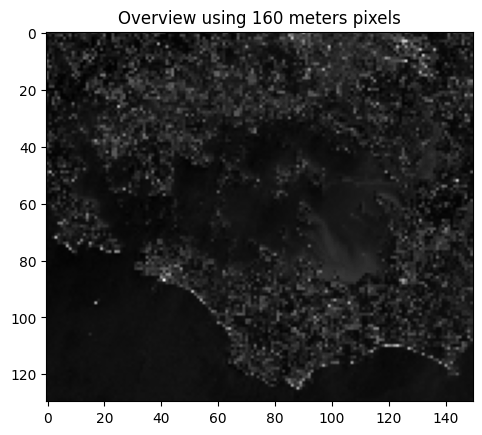

In [7]:
with rasterio.open(image_cog) as src:
    print(f"Original image size: {src.width} x {src.height}\n")

    # liste of overviews (for the first band)
    overview_levels = src.overviews(1)

    # Iterate over the overviews
    for n_overview, overview_factor in enumerate(overview_levels, start=1):
        overview_width = src.width // overview_factor
        overview_height = src.height // overview_factor
        pixel_size = int(src.res[0] * overview_factor)
        print(f"Overview {n_overview} of size {overview_width} x {overview_height} => pixel size: {pixel_size} meters")
        start_time = time.time()
        overview_data = src.read(1, out_shape=(src.height // src.overviews(1)[n_overview - 1],  # read the data from the overview
                                               src.width // src.overviews(1)[n_overview - 1]))
        overview_time = time.time() - start_time
        print(f"Load time {overview_factor}: {overview_time:.4f} seconds\n")

    # plot the last overview to compare the quality of the image
    plt.imshow(overview_data, cmap="gray")
    plt.title(f"Overview using {pixel_size} meters pixels")
    plt.show()

With only the second overview, the time needed to load the data into memory is divided by a factor of approximately 10 (this factor may vary depending on the machine you are using). The displayed image is the data loaded from the last overview (the one with the lowest resolution).

## Conclusion

Choosing a raster format depends on the desired performance and infrastructure. Locally, if storage space is a priority, JPEG2000 is preferable; on the other hand, if execution speed is more important, GeoTIFF is more suitable. Additionally, GeoTIFF is generally more widely supported than JPEG2000. In a cloud environment, COG is usually the best choice as it is optimized for this usage context. In summary:

| Format   | Advantages                                              | Limitations                                                                |
|----------|---------------------------------------------------------|---------------------------------------------------------------------------|
| JPEG2000 | Better compression                                      | Slower compression/decompression speed, not optimized for cloud           |
| GeoTIFF  | Faster, native support for geospatial metadata          | Larger files, not optimized for cloud                                     |
| COG      | Cloud optimized (speed, resources)                      | Less advantageous for local use                                           |